# TMD 2024
### Lucas Poma
## Trabajo Practico 4


## Imports

In [1]:
install.packages("xgboost")
require(xgboost)
install.packages("randomForest")
library("randomForest")
install.packages("kernlab")
library(kernlab)
install.packages("e1071")
library("e1071")
install.packages("caret")
library(caret)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xgboost

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:kernlab’:

    alpha


## Datasets

In [3]:
load("/content/TP4.Rdata")
load("/content/lampone.Rdata")
ls()

[1] "diag_test"  "diag_train" "esp_test"   "esp_train"  "lampone"   
[6] "RRL"

## Ejercicio 1

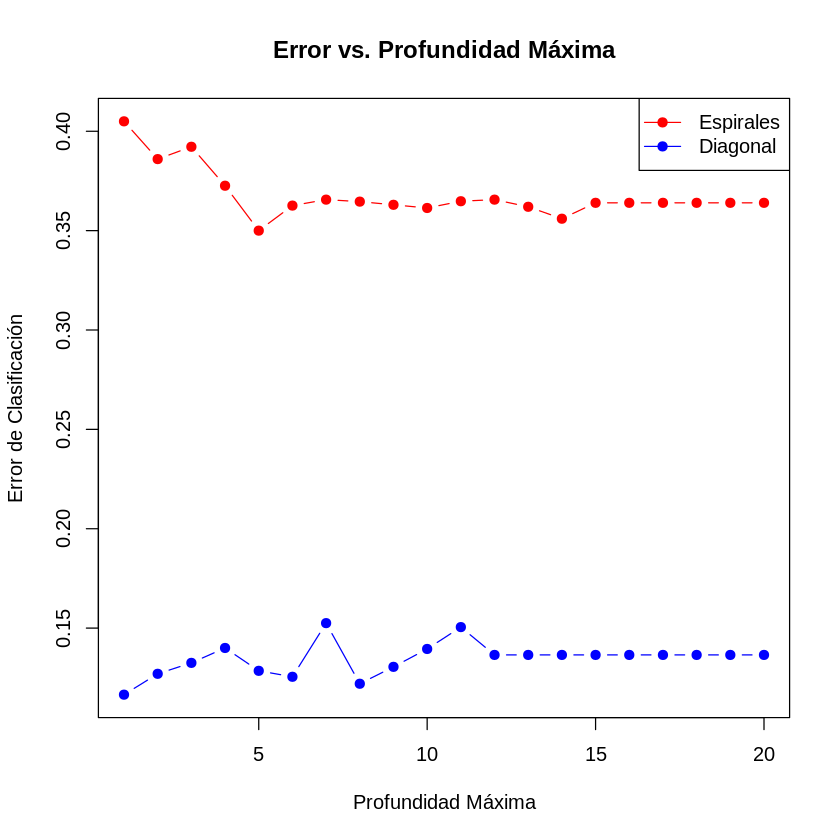

In [ ]:
evaluate_depth_error <- function(train_data, test_data, nrounds, eta, max_depth_range) {
    x.train <- as.matrix(train_data[, 1:2])
    y.train <- train_data[, 3]
    x.test <- as.matrix(test_data[, 1:2])
    y.test <- test_data[, 3]

    test_error <- numeric(length(max_depth_range))

    for (depth in max_depth_range) {
        model <- xgboost(
            data = x.train,
            label = as.integer(y.train) - 1,
            objective = "binary:hinge",
            nrounds = nrounds,
            eta = eta,
            max.depth = depth,
            colsample_bytree = 1,
            subsample = 1,
            verbose = 0
        )
        predictions <- predict(model, x.test)
        test_error[depth] <- mean(predictions != (as.integer(y.test) - 1))
    }
    return(test_error)
}

XGB.nrounds <- 200
XGB.eta <- 0.1
max_depth_range <- 1:20

esp_test_error <- evaluate_depth_error(esp_train, esp_test, XGB.nrounds, XGB.eta, max_depth_range)
diag_test_error <- evaluate_depth_error(diag_train, diag_test, XGB.nrounds, XGB.eta, max_depth_range)

plot(
    max_depth_range,
    esp_test_error,
    type = "b",
    pch = 19,
    col = "red",
    xlab = "Profundidad Máxima",
    ylab = "Error de Clasificación",
    main = "Error vs. Profundidad Máxima",
    ylim = range(c(esp_test_error, diag_test_error))
)
lines(max_depth_range, diag_test_error, type = "b", pch = 19, col = "blue")
legend(
    "topright",
    legend = c("Espirales", "Diagonal"),
    col = c("red", "blue"),
    pch = 19,
    lty = 1
)


El clasificador presenta un rendimiento pobre en el dataset de espirales ruidosas, lo que refleja la dificultad del modelo para capturar relaciones no lineales complejas en presencia de ruido. Al analizar la profundidad máxima de los árboles, observamos que al incrementarla, el error disminuye inicialmente pero alcanza un punto de estabilización donde el rendimiento se mantiene constante. Esto sugiere que profundidades mayores no aportan beneficios significativos.

Por otro lado, en un dataset mas simple y separable linealmente, el de diagonales, profundidades máximas más pequeñas tienden a mostrar un mejor desempeño. Esto se debe a que, en estos casos, un modelo más sencillo puede generalizar mejor.

## Ejercicio 2

In [17]:
summary(RRL)
RRL.feat <- RRL[, !names(RRL) %in% "Tipo"]
RRL.classes <- RRL$Tipo

   Amplitude       AndersonDarling  Autocor_length    Beyond1Std      
 Min.   :0.01550   Min.   :0.1237   Min.   :1.000   Min.   :0.007143  
 1st Qu.:0.09469   1st Qu.:0.9474   1st Qu.:1.000   1st Qu.:0.228361  
 Median :0.14950   Median :1.0000   Median :1.000   Median :0.271930  
 Mean   :0.15444   Mean   :0.9109   Mean   :1.252   Mean   :0.258909  
 3rd Qu.:0.19300   3rd Qu.:1.0000   3rd Qu.:1.000   3rd Qu.:0.307295  
 Max.   :1.57950   Max.   :1.0000   Max.   :7.000   Max.   :0.638060  
    CAR_mean          CAR_sigma            CAR_tau             Con           
 Min.   :     0.0   Min.   :-57.33259   Min.   :      0   Min.   :0.0000000  
 1st Qu.:    24.0   1st Qu.: -0.16407   1st Qu.:      0   1st Qu.:0.0000000  
 Median :    27.5   Median :  0.00000   Median :      1   Median :0.0000000  
 Mean   :  9695.5   Mean   :  0.45900   Mean   :   7144   Mean   :0.0004529  
 3rd Qu.:   149.2   3rd Qu.:  0.00459   3rd Qu.:      1   3rd Qu.:0.0000000  
 Max.   :773430.0   Max.   :208.874

[1] 7060

Error Promedio OOB Minimo: 0.03886686 
MTRY correspondiente: 17 


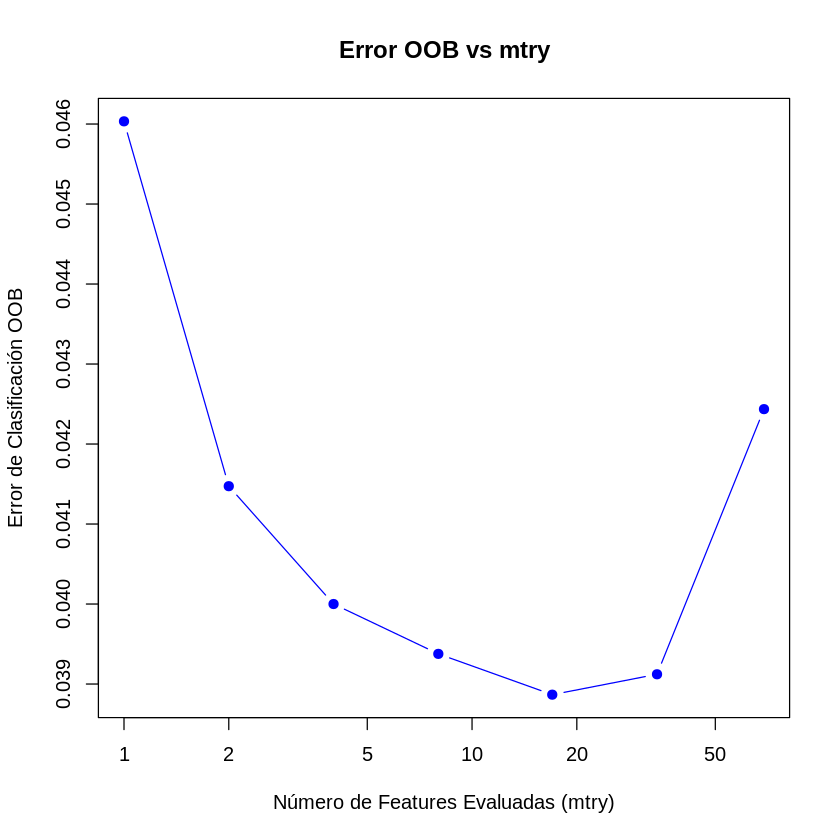

In [ ]:
total_features <- ncol(RRL.feat)
mtrys <- 0:floor(log(total_features, 2))
mtry_values <- floor(total_features / (2 ^ mtrys))
num_runs <- 5
oob_errors <- numeric(length(mtry_values))
n_trees = 1000

for (i in seq_along(mtry_values)) {
    mtry <- mtry_values[i]
    run_errors <- numeric(num_runs)

    for (run in 1:num_runs) {
        rf_model <- randomForest(
            x = RRL.feat,
            y = RRL.classes,
            ntree = n_trees,
            mtry = mtry,
            importance = FALSE
        )
        run_errors[run] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
    }

    oob_errors[i] <- mean(run_errors)
}

plot(
    mtry_values,
    oob_errors,
    type = "b",
    pch = 19,
    col = "blue",
    xlab = "Número de Features Evaluadas (mtry)",
    ylab = "Error de Clasificación OOB",
    main = "Error OOB vs mtry",
    log = "x"
)

min_error_index <- which.min(oob_errors)
min_oob_error <- oob_errors[min_error_index]
best_mtry <- mtry_values[min_error_index]

cat("Error Promedio OOB Minimo:", min_oob_error, "\n")
cat("MTRY correspondiente:", best_mtry, "\n")

Observamos que el minimo error promedio obtenido utilizando estimacion OOB se obtuvo utilizando 17 features de las 69 presentes.

Ya el error es bastante bajo de por si, utilizando 8 features que es mas cercano a sqrt(total_features).

Vemos que los extremos es donde peores resultados se obtienen.

## Ejercicio 3

### Funciones

In [20]:
options(warn = -1)

#### Random Forest

In [21]:
evaluate_rf_oob <- function(features, classes, num_runs = 5, n_trees = 1000) {
    total_features <- ncol(features)
    mtrys <- 0:floor(log(total_features, 2))
    mtry_values <- floor(total_features / (2 ^ mtrys))
    oob_errors <- numeric(length(mtry_values))

    for (i in seq_along(mtry_values)) {
        mtry <- mtry_values[i]
        run_errors <- numeric(num_runs)

        for (run in 1:num_runs) {
            rf_model <- randomForest(
                x = features,
                y = classes,
                ntree = n_trees,
                mtry = mtry,
                importance = FALSE
            )
            run_errors[run] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
        }

        oob_errors[i] <- mean(run_errors)
    }

    min_error_index <- which.min(oob_errors)
    min_oob_error <- oob_errors[min_error_index]
    best_mtry <- mtry_values[min_error_index]

    return(list(
        oob_errors = oob_errors,
        mtry_values = mtry_values,
        min_oob_error = min_oob_error,
        best_mtry = best_mtry
    ))
}


#### Boosting

In [22]:
evaluate_boosting_cv <- function(data, labels, nrounds, eta_values, max_depth_range, k_folds) {
    folds <- createFolds(labels, k = k_folds, list = TRUE, returnTrain = FALSE)
    results <- data.frame(eta = numeric(), max_depth = integer(), fold = integer(), error = numeric())

    for (eta in eta_values) {
        for (depth in max_depth_range) {
            for (fold_idx in seq_along(folds)) {
                test_idx <- folds[[fold_idx]]
                train_idx <- setdiff(seq_along(labels), test_idx)

                x.train <- as.matrix(data[train_idx, ])
                y.train <- labels[train_idx]
                x.test <- as.matrix(data[test_idx, ])
                y.test <- labels[test_idx]

                model <- xgboost(
                    data = x.train,
                    label = as.integer(y.train) - 1,
                    objective = "binary:hinge",
                    nrounds = nrounds,
                    eta = eta,
                    max.depth = depth,
                    colsample_bytree = 1,
                    subsample = 1,
                    verbose = 0
                )

                predictions <- predict(model, x.test)
                pred_class <- ifelse(predictions > 0.5, 1, 0)
                error <- mean(pred_class != (as.integer(y.test) - 1))

                results <- rbind(results, data.frame(
                    eta = eta,
                    max_depth = depth,
                    fold = fold_idx,
                    error = error
                ))
            }
        }
    }

    summary_results <- aggregate(error ~ eta + max_depth, data = results, mean)
    best_result <- summary_results[which.min(summary_results$error), ]

    return(list(
        summary_results = summary_results,
        best_error = best_result$error,
        best_eta = best_result$eta,
        best_max_depth = best_result$max_depth
    ))
}


#### SVM Polinomial

In [23]:
evaluate_svm_polynomial_cv <- function(data, labels, degree_range, cost_range, k_folds) {
    folds <- createFolds(labels, k = k_folds, list = TRUE, returnTrain = FALSE)
    results <- data.frame(degree = integer(), cost = numeric(), fold = integer(), error = numeric())

    for (degree in degree_range) {
        for (cost in cost_range) {
            for (fold_idx in seq_along(folds)) {
                test_idx <- folds[[fold_idx]]
                train_idx <- setdiff(seq_along(labels), test_idx)

                x.train <- data[train_idx, ]
                y.train <- labels[train_idx]
                x.test <- data[test_idx, ]
                y.test <- labels[test_idx]

                model <- svm(
                    x = x.train,
                    y = as.factor(y.train),
                    kernel = "polynomial",
                    degree = degree,
                    cost = cost,
                    scale = TRUE
                )

                predictions <- predict(model, x.test)
                error <- mean(predictions != y.test)

                results <- rbind(results, data.frame(
                    degree = degree,
                    cost = cost,
                    fold = fold_idx,
                    error = error
                ))
            }
        }
    }

    summary_results <- aggregate(error ~ degree + cost, data = results, mean)
    best_result <- summary_results[which.min(summary_results$error), ]

    return(list(
        summary_results = summary_results,
        best_error = best_result$error,
        best_degree = best_result$degree,
        best_cost = best_result$cost
    ))
}


#### SVM RBF

In [24]:
evaluate_svm_rbf_cv <- function(data, labels, cost_range, gamma_range, k_folds) {
    folds <- createFolds(labels, k = k_folds, list = TRUE, returnTrain = FALSE)
    results <- data.frame(cost = numeric(), gamma = numeric(), fold = integer(), error = numeric())

    for (cost in cost_range) {
        for (gamma in gamma_range) {
            for (fold_idx in seq_along(folds)) {
                test_idx <- folds[[fold_idx]]
                train_idx <- setdiff(seq_along(labels), test_idx)

                x.train <- data[train_idx, ]
                y.train <- labels[train_idx]
                x.test <- data[test_idx, ]
                y.test <- labels[test_idx]

                model <- svm(
                    x = x.train,
                    y = as.factor(y.train),
                    kernel = "radial",
                    cost = cost,
                    gamma = gamma,
                    scale = TRUE
                )

                predictions <- predict(model, x.test)
                error <- mean(predictions != y.test)

                results <- rbind(results, data.frame(
                    cost = cost,
                    gamma = gamma,
                    fold = fold_idx,
                    error = error
                ))
            }
        }
    }

    summary_results <- aggregate(error ~ cost + gamma, data = results, mean)
    best_result <- summary_results[which.min(summary_results$error), ]

    return(list(
        summary_results = summary_results,
        best_error = best_result$error,
        best_cost = best_result$cost,
        best_gamma = best_result$gamma
    ))
}


### Lampone

In [19]:
lampone.feat <- lampone[, -c(1, 143, 144)]
lampone.classes <- lampone[, c(143)]
nrow(lampone)

[1] 49

Como tenemos pocos samples, utilizamos k-fold crossvalidation, para estimar el error de test en los metodos que no son RF, ya que ahi podemos utilizar OOB estimation sin problemas

#### Random Forest

Lampone Dataset:
Error Promedio OOB Minimo: 0.08163265 
MTRY correspondiente: 17 


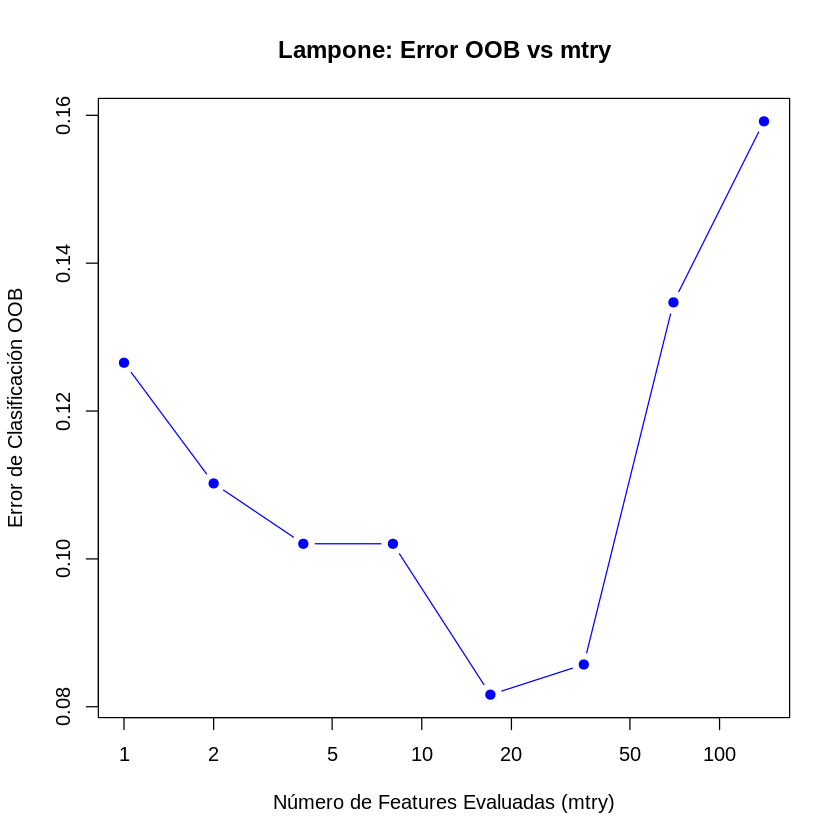

In [ ]:
num_runs <- 5
n_trees = 1000

lampone_results <- evaluate_rf_oob(lampone.feat, lampone.classes, num_runs, n_trees)

cat("Lampone Dataset:\n")
cat("Error Promedio OOB Minimo:", lampone_results$min_oob_error, "\n")
cat("MTRY correspondiente:", lampone_results$best_mtry, "\n")

plot(
    lampone_results$mtry_values,
    lampone_results$oob_errors,
    type = "b",
    pch = 19,
    col = "blue",
    xlab = "Número de Features Evaluadas (mtry)",
    ylab = "Error de Clasificación OOB",
    main = "Lampone: Error OOB vs mtry",
    log = "x"
)

#### Boosting

Lampone Dataset:
Mejor Error: 0.100404 
Eta correspondiente: 0.1 
Profundidad Máxima correspondiente: 2 


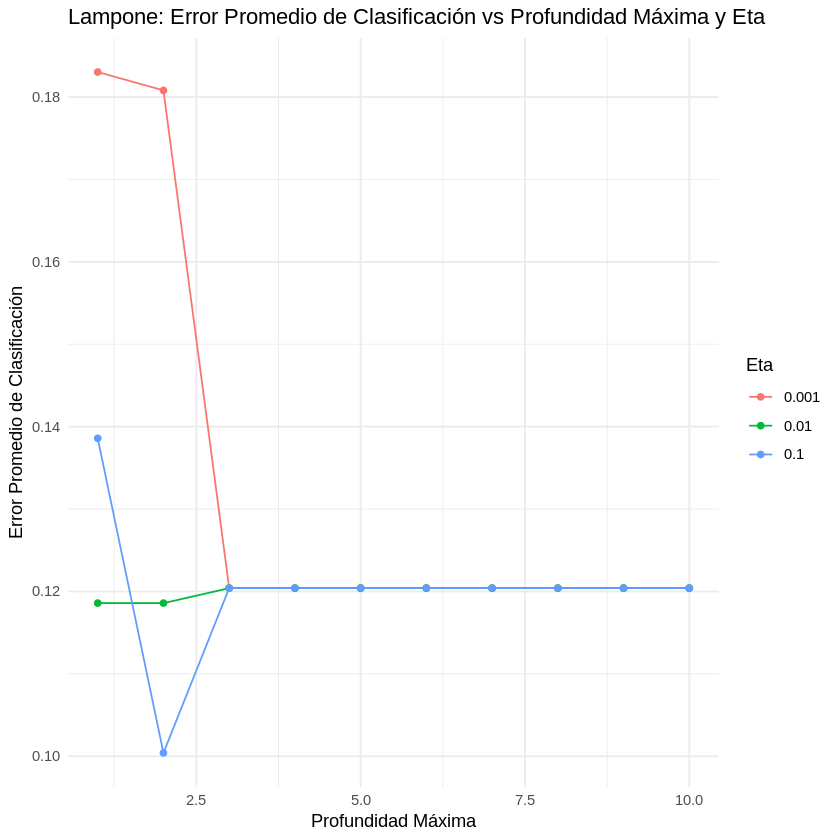

In [25]:
XGB.nrounds <- 2500
eta_values <- c(0.001, 0.01, 0.1)
max_depth_range <- 1:10
k_folds <- 5

lampone_results <- evaluate_boosting_cv(lampone.feat, lampone.classes, XGB.nrounds, eta_values, max_depth_range, k_folds)

cat("Lampone Dataset:\n")
cat("Mejor Error:", lampone_results$best_error, "\n")
cat("Eta correspondiente:", lampone_results$best_eta, "\n")
cat("Profundidad Máxima correspondiente:", lampone_results$best_max_depth, "\n")

ggplot(lampone_results$summary_results, aes(x = max_depth, y = error, color = as.factor(eta), group = eta)) +
    geom_line() +
    geom_point() +
    scale_color_discrete(name = "Eta") +
    labs(
        x = "Profundidad Máxima",
        y = "Error Promedio de Clasificación",
        title = "Lampone: Error Promedio de Clasificación vs Profundidad Máxima y Eta"
    ) +
    theme_minimal()

#### SVM Polinomial

Lampone Dataset:
Mejor Error: 0.1044444 
Grado correspondiente: 1 
Costo correspondiente: 100 


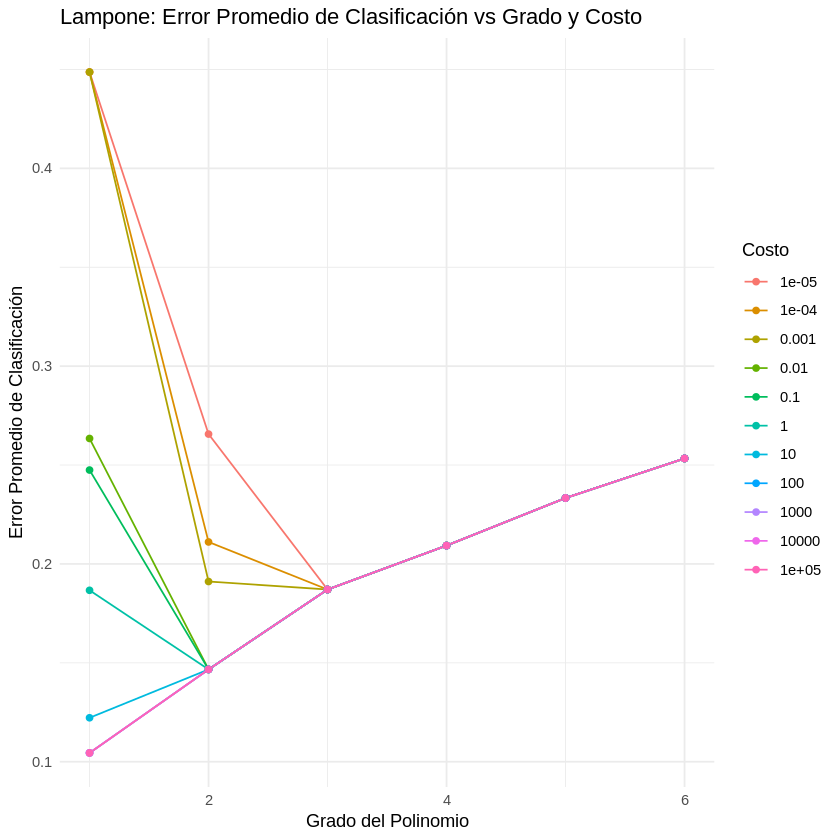

In [ ]:
degree_range <- 1:6
cost_range <- 10^(-5:5)
k_folds <- 5

lampone_svm_results <- evaluate_svm_polynomial_cv(lampone.feat, lampone.classes, degree_range, cost_range, k_folds)

cat("Lampone Dataset:\n")
cat("Mejor Error:", lampone_svm_results$best_error, "\n")
cat("Grado correspondiente:", lampone_svm_results$best_degree, "\n")
cat("Costo correspondiente:", lampone_svm_results$best_cost, "\n")

ggplot(lampone_svm_results$summary_results, aes(x = degree, y = error, color = as.factor(cost), group = cost)) +
    geom_line() +
    geom_point() +
    scale_color_discrete(name = "Costo") +
    labs(
        x = "Grado del Polinomio",
        y = "Error Promedio de Clasificación",
        title = "Lampone: Error Promedio de Clasificación vs Grado y Costo"
    ) +
    theme_minimal()

#### SVM RBF

Lampone Dataset:
Mejor Error: 0.1408081 
Costo correspondiente: 1e+05 
Gamma correspondiente: 1e-05 


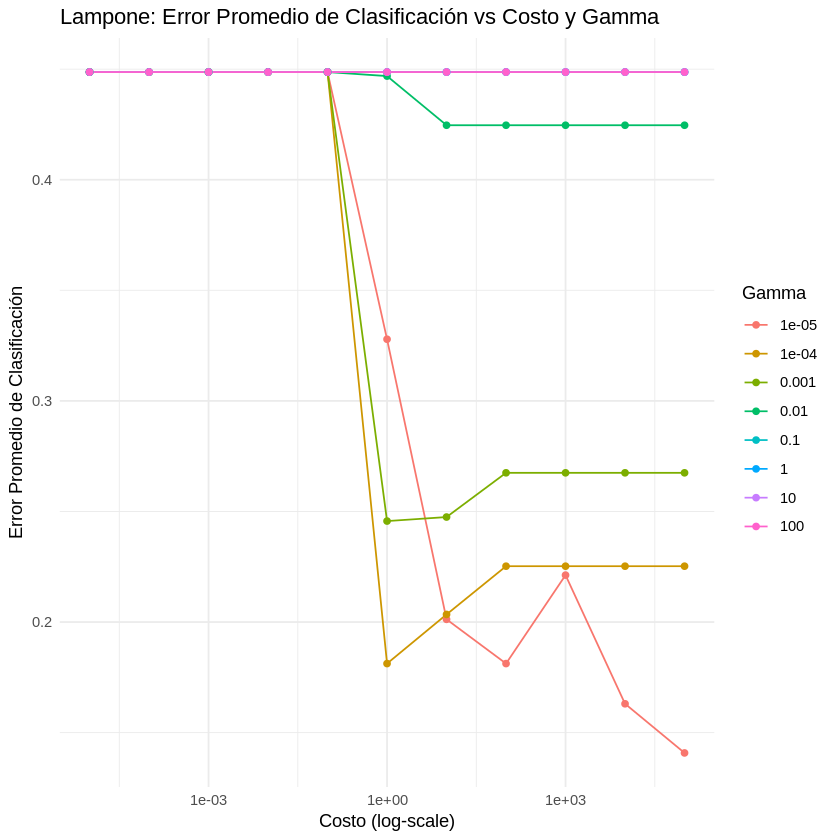

In [ ]:
cost_range <- 10^(-5:5)
gamma_range <- 10^(-5:2)
k_folds <- 5

lampone_svm_rbf_results <- evaluate_svm_rbf_cv(lampone.feat, lampone.classes, cost_range, gamma_range, k_folds)

cat("Lampone Dataset:\n")
cat("Mejor Error:", lampone_svm_rbf_results$best_error, "\n")
cat("Costo correspondiente:", lampone_svm_rbf_results$best_cost, "\n")
cat("Gamma correspondiente:", lampone_svm_rbf_results$best_gamma, "\n")

ggplot(lampone_svm_rbf_results$summary_results, aes(x = cost, y = error, color = as.factor(gamma), group = gamma)) +
    geom_line() +
    geom_point() +
    scale_x_log10() +
    scale_color_discrete(name = "Gamma") +
    labs(
        x = "Costo (log-scale)",
        y = "Error Promedio de Clasificación",
        title = "Lampone: Error Promedio de Clasificación vs Costo y Gamma"
    ) +
    theme_minimal()

### Comentarios

En el caso de Random Forest (RF), observamos que el mejor error se obtuvo con un mtry de 17, siendo este el error más bajo entre todos los métodos evaluados. Sin embargo, esto podría deberse a la limitada cantidad de muestras disponibles.

Por su parte, en XGBoost utilizamos 2500 árboles, siguiendo la recomendación teórica de seleccionar un valor alto para evitar overfitting. Ajustamos los parámetros eta y max_depth, y confirmamos que, como vimos en el Ejercicio 1, a altas profundidades el error tiende a estabilizarse, además de que las diferentes tasas de aprendizaje (eta) convergen. El mejor resultado se logró con un eta de 0.1 y una profundidad máxima de 2.

En el caso de SVM con kernel polinomial, tuneamos los parámetros de costo y el grado del polinomio, obteniendo el mejor resultado con un grado de 1 y un costo de 100. A medida que el grado del polinomio aumenta, los errores asociados a todos los costos parecen converger.

Para SVM con kernel RBF, ajustamos los parámetros gamma y costo. El mejor resultado se obtuvo con el costo más alto y el valor más bajo de gamma. Sin embargo, este método presentó el peor desempeño entre los evaluados, probablemente porque el conjunto de datos tiene una distribución más lineal que radial.

En síntesis, el mejor desempeño se lo lleva RF, seguido de cerca por XGBoost y SVM Polinomial, cuyos resultados son similares. En contraste, SVM con kernel RBF mostró el peor desempeño. Es importante tener en cuenta que los resultados podrían estar influenciados por la pequeña cantidad de muestras y el uso de validación cruzada para la estimación de errores.

## Ejercicio 4

### Funciones

#### Boosting

In [12]:
evaluate_boosting <- function(data, labels, nrounds, eta_values, max_depth_range, train_fraction = 0.8) {

  n_samples <- nrow(data)

  train_indices <- sample(1:n_samples, size = train_fraction * n_samples)
  test_indices <- setdiff(1:n_samples, train_indices)

  x.train <- as.matrix(data[train_indices, ])
  y.train <- labels[train_indices]
  x.test <- as.matrix(data[test_indices, ])
  y.test <- labels[test_indices]

  results <- data.frame(eta = numeric(), max_depth = integer(), error = numeric())

  for (eta in eta_values) {
    for (depth in max_depth_range) {
      model <- xgboost(
        data = x.train,
        label = as.integer(y.train) - 1,
        nrounds = nrounds,
        eta = eta,
        max.depth = depth,
        objective = "binary:hinge",
        colsample_bytree = 1,
        subsample = 1,
        verbose = 0
      )

      predictions <- predict(model, x.test)
      pred_class <- ifelse(predictions > 0.5, 1, 0)
      error <- mean(pred_class != (as.integer(y.test) - 1))

      results <- rbind(results, data.frame(
        eta = eta,
        max_depth = depth,
        error = error
      ))
    }
  }

  summary_results <- aggregate(error ~ eta + max_depth, data = results, mean)
  best_result <- summary_results[which.min(summary_results$error), ]

  return(list(
    summary_results = summary_results,
    best_error = best_result$error,
    best_eta = best_result$eta,
    best_max_depth = best_result$max_depth
  ))
}

#### SVM Polinomial

In [13]:
evaluate_svm_polynomial <- function(data, labels, degree_range, cost_range, train_fraction = 0.8) {

  n_samples <- nrow(data)

  train_indices <- sample(1:n_samples, size = train_fraction * n_samples)
  test_indices <- setdiff(1:n_samples, train_indices)

  x.train <- data[train_indices, ]
  y.train <- labels[train_indices]
  x.test <- data[test_indices, ]
  y.test <- labels[test_indices]

  results <- data.frame(degree = integer(), cost = numeric(), error = numeric())

  for (degree in degree_range) {
    for (cost in cost_range) {
      model <- svm(
        x = x.train,
        y = as.factor(y.train),
        kernel = "polynomial",
        degree = degree,
        cost = cost,
        scale = TRUE
      )

      predictions <- predict(model, x.test)
      error <- mean(predictions != y.test)

      results <- rbind(results, data.frame(
        degree = degree,
        cost = cost,
        error = error
      ))
    }
  }

  summary_results <- aggregate(error ~ degree + cost, data = results, mean)
  best_result <- summary_results[which.min(summary_results$error), ]

  return(list(
    summary_results = summary_results,
    best_error = best_result$error,
    best_degree = best_result$degree,
    best_cost = best_result$cost
  ))
}

#### SVM RBF

In [14]:
evaluate_svm_rbf <- function(data, labels, cost_range, gamma_range, train_fraction = 0.8) {

  n_samples <- nrow(data)

  train_indices <- sample(1:n_samples, size = train_fraction * n_samples)
  test_indices <- setdiff(1:n_samples, train_indices)

  x.train <- data[train_indices, ]
  y.train <- labels[train_indices]
  x.test <- data[test_indices, ]
  y.test <- labels[test_indices]

  results <- data.frame(cost = numeric(), gamma = numeric(), error = numeric())

  for (cost in cost_range) {
    for (gamma in gamma_range) {
      model <- svm(
        x = x.train,
        y = as.factor(y.train),
        kernel = "radial",
        cost = cost,
        gamma = gamma,
        scale = TRUE
      )

      predictions <- predict(model, x.test)
      error <- mean(predictions != y.test)

      results <- rbind(results, data.frame(
        cost = cost,
        gamma = gamma,
        error = error
      ))
    }
  }

  summary_results <- aggregate(error ~ cost + gamma, data = results, mean)
  best_result <- summary_results[which.min(summary_results$error), ]

  return(list(
    summary_results = summary_results,
    best_error = best_result$error,
    best_cost = best_result$cost,
    best_gamma = best_result$gamma
  ))
}

### RRL

In [18]:
rrl.feat <- RRL[, !names(RRL) %in% "Tipo"]
rrl.classes <- RRL$Tipo
nrow(RRL)

[1] 7060

Como no tenemos una cantidad de samples acotada como en el ejercicio anterior, procedemos sin k-fold crossvalidation y simplemente separamos training de test 80-20.

#### Random Forest

RRL Dataset:
Error Promedio OOB Minimo: 0.03886686 
MTRY correspondiente: 17 


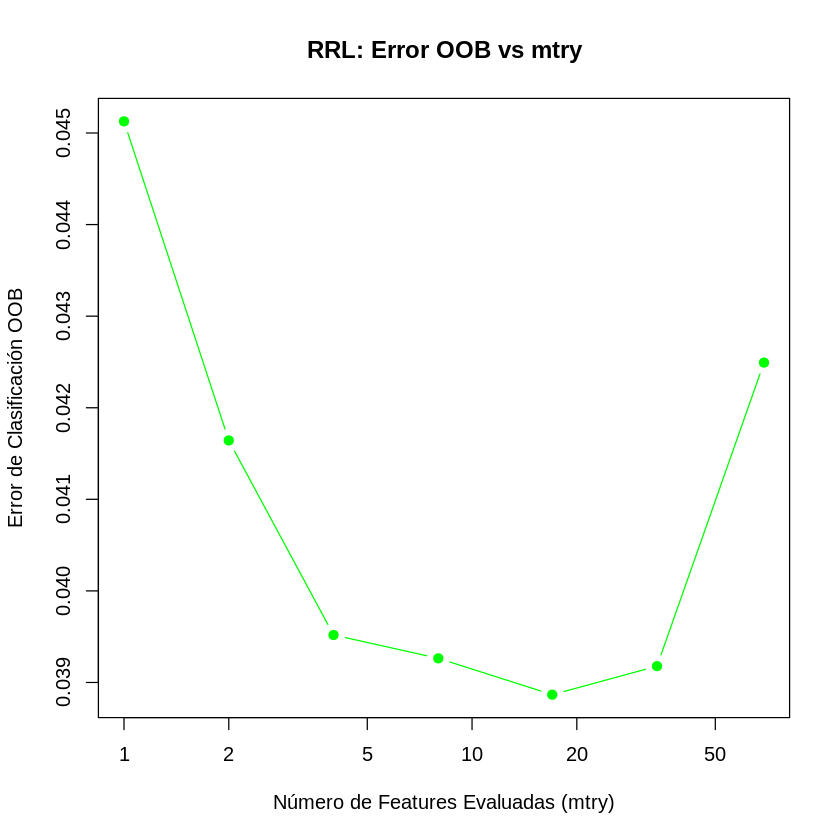

In [ ]:
num_runs <- 5
n_trees = 1000

rrl_results <- evaluate_rf_oob(rrl.feat, rrl.classes, num_runs, n_trees)

cat("RRL Dataset:\n")
cat("Error Promedio OOB Minimo:", rrl_results$min_oob_error, "\n")
cat("MTRY correspondiente:", rrl_results$best_mtry, "\n")

plot(
    rrl_results$mtry_values,
    rrl_results$oob_errors,
    type = "b",
    pch = 19,
    col = "green",
    xlab = "Número de Features Evaluadas (mtry)",
    ylab = "Error de Clasificación OOB",
    main = "RRL: Error OOB vs mtry",
    log = "x"
)

#### Boosting

RRL Dataset:
Mejor Error: 0.03045326 
Eta correspondiente: 0.01 
Profundidad Maxima correspondiente: 3 


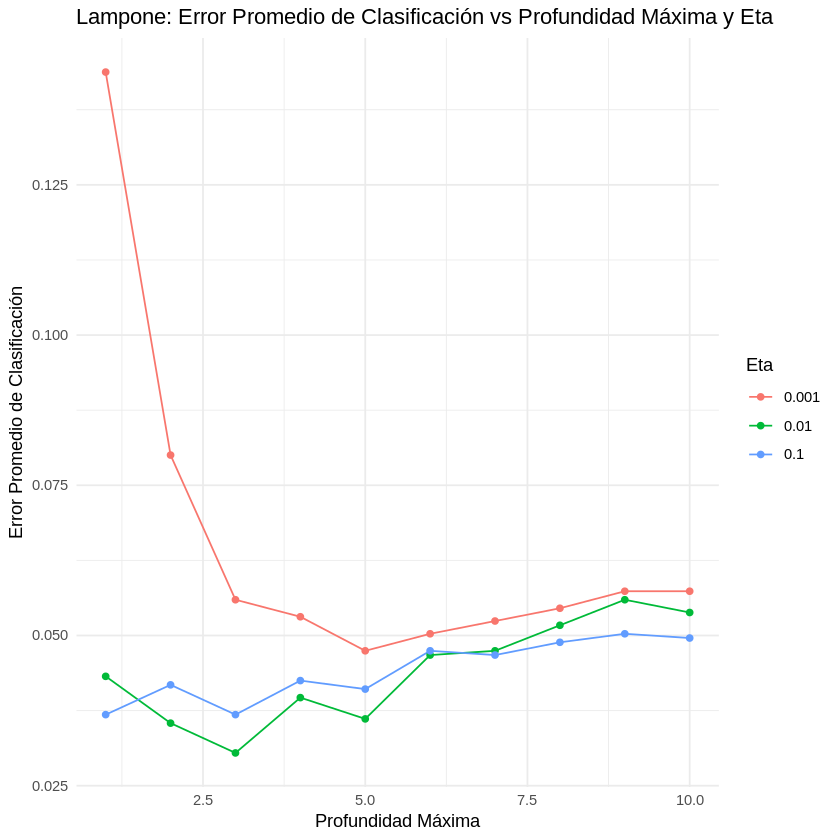

In [10]:
nrounds <- 2500
eta_values <- c(0.001, 0.01, 0.1)
max_depth_range <- 1:10

rrl_results <- evaluate_boosting(rrl.feat, rrl.classes, nrounds, eta_values, max_depth_range)

cat("RRL Dataset:\n")
cat("Mejor Error:", rrl_results$best_error, "\n")
cat("Eta correspondiente:", rrl_results$best_eta, "\n")
cat("Profundidad Maxima correspondiente:", rrl_results$best_max_depth, "\n")

ggplot(rrl_results$summary_results, aes(x = max_depth, y = error, color = as.factor(eta), group = eta)) +
    geom_line() +
    geom_point() +
    scale_color_discrete(name = "Eta") +
    labs(
        x = "Profundidad Máxima",
        y = "Error Promedio de Clasificación",
        title = "Lampone: Error Promedio de Clasificación vs Profundidad Máxima y Eta"
    ) +
    theme_minimal()


#### SVM Polinomial

RRL Dataset:
Mejor Error: 0.1041076 
Grado correspondiente: 1 
Costo correspondiente: 100 


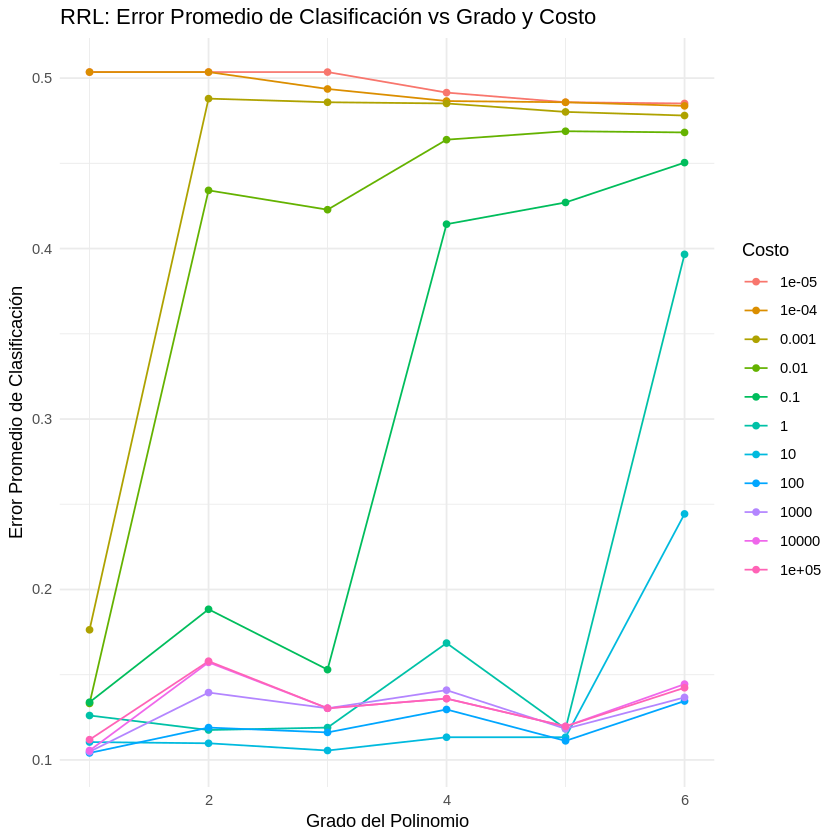

In [15]:
degree_range <- 1:6
cost_range <- 10^(-5:5)

rrl_svm_results <- evaluate_svm_polynomial(rrl.feat, rrl.classes, degree_range, cost_range)

cat("RRL Dataset:\n")
cat("Mejor Error:", rrl_svm_results$best_error, "\n")
cat("Grado correspondiente:", rrl_svm_results$best_degree, "\n")
cat("Costo correspondiente:", rrl_svm_results$best_cost, "\n")

ggplot(rrl_svm_results$summary_results, aes(x = degree, y = error, color = as.factor(cost), group = cost)) +
    geom_line() +
    geom_point() +
    scale_color_discrete(name = "Costo") +
    labs(
        x = "Grado del Polinomio",
        y = "Error Promedio de Clasificación",
        title = "RRL: Error Promedio de Clasificación vs Grado y Costo"
    ) +
    theme_minimal()

#### SVM RBF

rrl Dataset:
Mejor Error: 0.07507082 
Costo correspondiente: 10 
Gamma correspondiente: 0.01 


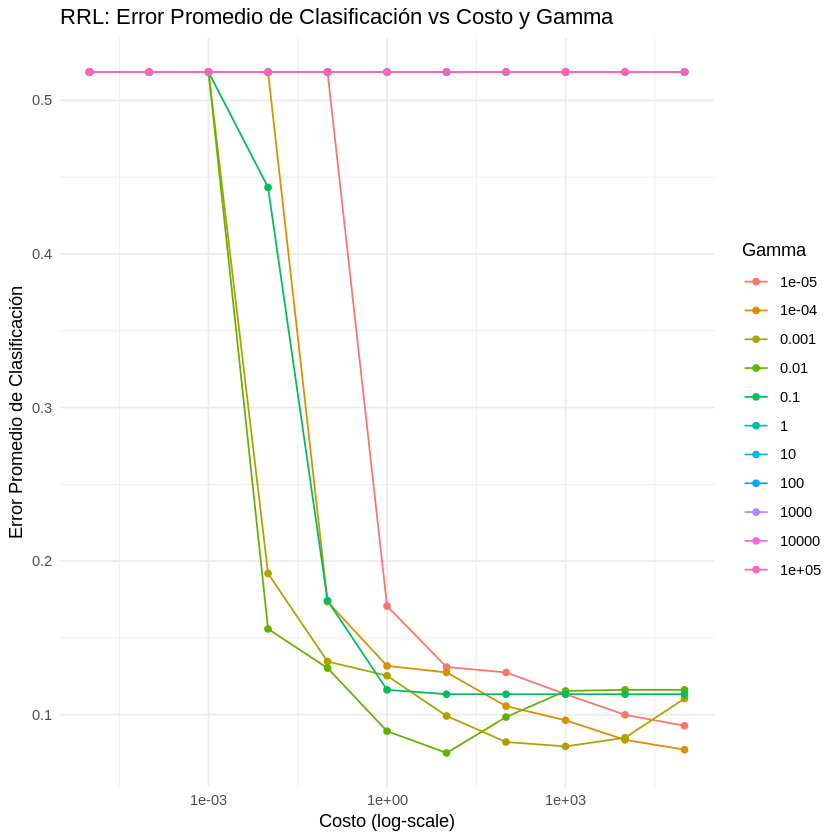

In [16]:
cost_range <- 10^(-5:5)
gamma_range <- 10^(-5:5)

rrl_svm_rbf_results <- evaluate_svm_rbf(rrl.feat, rrl.classes, cost_range, gamma_range)

cat("rrl Dataset:\n")
cat("Mejor Error:", rrl_svm_rbf_results$best_error, "\n")
cat("Costo correspondiente:", rrl_svm_rbf_results$best_cost, "\n")
cat("Gamma correspondiente:", rrl_svm_rbf_results$best_gamma, "\n")

ggplot(rrl_svm_rbf_results$summary_results, aes(x = cost, y = error, color = as.factor(gamma), group = gamma)) +
    geom_line() +
    geom_point() +
    scale_x_log10() +
    scale_color_discrete(name = "Gamma") +
    labs(
        x = "Costo (log-scale)",
        y = "Error Promedio de Clasificación",
        title = "RRL: Error Promedio de Clasificación vs Costo y Gamma"
    ) +
    theme_minimal()

### Comentarios

En el caso de Random Forest (RF), ya analizado en el Ejercicio 2, confirmamos que los resultados obtenidos coinciden con los previos.

En XGBoost, utilizamos 2500 árboles, como mencionamos anteriormente. Ajustamos los parámetros eta y max_depth, observando nuevamente que a altas profundidades el error tiende a estabilizarse, aunque en esta ocasión no de manera tan marcada. El mejor resultado se logró con un eta de 0.01 y una profundidad máxima de 3, superando a RF, tal como se anticipa en la teoría.

Para SVM con kernel polinomial, los mejores resultados se obtuvieron con costos elevados, destacándose el caso de un costo de 100 y un grado de 1. Sin embargo, este método presentó el peor desempeño general.

En cuanto a SVM con kernel RBF, el mejor desempeño se logró con costos altos y valores moderados de gamma. Aunque este kernel tuvo un mejor rendimiento que el polinomial, su error fue superior al de XGBoost y RF, lo que sugiere que la distribución de los datos no es tan lineal.

En síntesis, el mejor desempeño lo alcanzó XGBoost, seguido muy de cerca por RF. Los métodos basados en SVM presentaron resultados significativamente inferiores, con errores que duplicaron los de los otros modelos.